In [1]:
pip install facenet-pytorch torch torchvision Pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  0%|          | 0.00/107M [00:00<?, ?B/s]

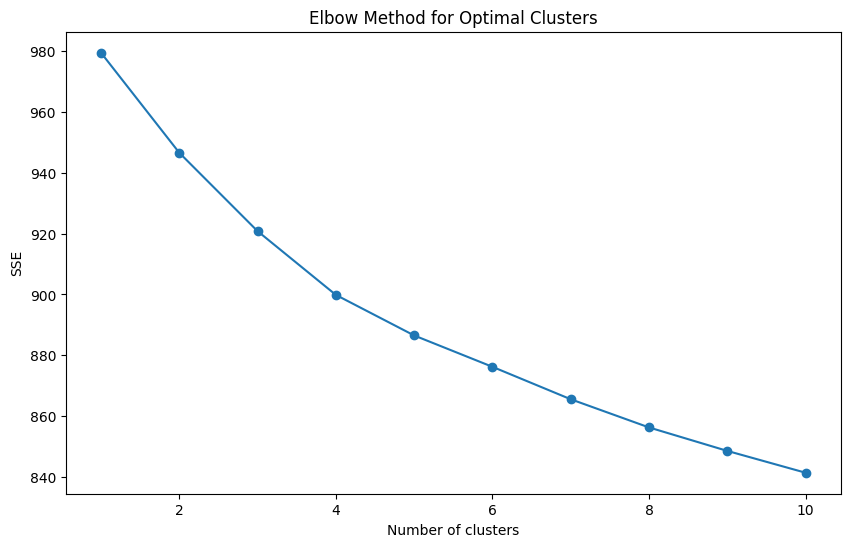

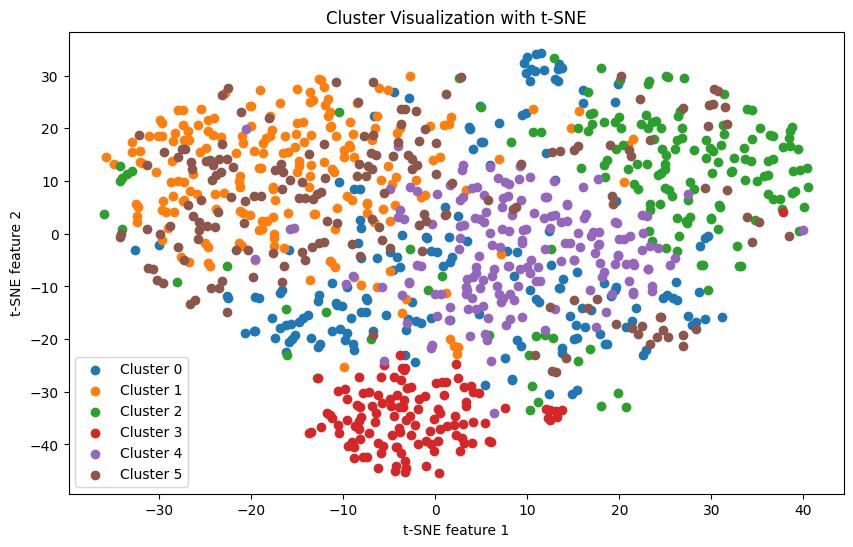

In [2]:
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import glob

# Initialize InceptionResnetV1 for generating embeddings
resnet = InceptionResnetV1(pretrained='vggface2').eval()

# Define the transformation: resize, convert to tensor, and normalize
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

images_folder = '/kaggle/input/face-test'
images_dir = os.listdir(images_folder)[:1000]

embeddings = []
processed_image_paths = []

# Vectorize faces
for img_name in images_dir:
    img_path = os.path.join(images_folder, img_name)
    image = Image.open(img_path).convert('RGB')
    img_transformed = transform(image)
    embedding = resnet(img_transformed.unsqueeze(0)).detach().numpy()
    embeddings.append(embedding.flatten())
    processed_image_paths.append(img_path)

embeddings = np.array(embeddings)

# Elbow Method to determine the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(embeddings)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# Choose an optimal number of clusters based on the elbow plot (for example, 5)
optimal_clusters = 6  # Adjust this based on your elbow plot observation
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0, n_init=10).fit(embeddings)

# Cluster Visualization with t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
for i in range(optimal_clusters):
    plt.scatter(tsne_results[kmeans.labels_ == i, 0], tsne_results[kmeans.labels_ == i, 1], label=f'Cluster {i}')
plt.title('Cluster Visualization with t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

# Create folders for each cluster and copy images accordingly
for cluster_id in range(10):
    os.makedirs(f'/kaggle/working/cluster_{cluster_id}', exist_ok=True)  # Use a writable directory

for img_path, cluster_label in zip(processed_image_paths, kmeans.labels_):
    destination = os.path.join(f'/kaggle/working/cluster_{cluster_label}', os.path.basename(img_path))
    shutil.copy(img_path, destination)  # Use copy instead of move


In [3]:
from PIL import Image
import numpy as np
import os
import glob

def generate_average_image(cluster_folder, output_path, target_size=(320, 320)):
    image_paths = glob.glob(os.path.join(cluster_folder, '*.png'))
    
    # Check if the image_paths list is empty
    if not image_paths:
        print(f"No PNG files found in {cluster_folder}. Skipping this cluster.")
        return

    # Initialize an empty array with the shape of the target size and the number of images
    sum_array = np.zeros((target_size[1], target_size[0], 3), dtype=np.float32)

    # Count the number of images processed to calculate the average
    num_images = 0

    # Resize and accumulate image data
    for image_path in image_paths:
        image = Image.open(image_path).convert('RGB')  # Convert to RGB to ensure 3 channels
        image = image.resize(target_size, Image.LANCZOS)  # High-quality downsampling filter
        image_array = np.array(image, dtype=np.float32)
        sum_array += image_array  # Add image data to the sum array
        num_images += 1

    # Calculate the average
    average_array = sum_array / num_images
    average_array = np.clip(average_array, 0, 255)  # Ensure the values are within valid range

    # Convert to uint8 and back to an image
    average_face = Image.fromarray(average_array.astype(np.uint8))

    # Save the average face image
    average_face.save(output_path)

# Example usage
# Replace 'path_to_your_cluster_folder' and 'path_to_your_output_folder' with actual paths
cluster_folder_path = '/kaggle/working/'
output_folder_path = '/kaggle/working/'

# Choose a target size for the average face images
uniform_target_size = (320, 320)  # You can modify this as needed

# Make sure the output directory exists
os.makedirs(output_folder_path, exist_ok=True)

# Generate average face images for each cluster with a uniform size
for i in range(10):  # Assuming 10 clusters
    cluster_folder = os.path.join(cluster_folder_path, f'cluster_{i}')  # Construct the full path
    output_path = os.path.join(output_folder_path, f'average_face_cluster_{i}.png')
    generate_average_image(cluster_folder, output_path, uniform_target_size)


No PNG files found in /kaggle/working/cluster_6. Skipping this cluster.
No PNG files found in /kaggle/working/cluster_7. Skipping this cluster.
No PNG files found in /kaggle/working/cluster_8. Skipping this cluster.
No PNG files found in /kaggle/working/cluster_9. Skipping this cluster.
